In [54]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns 
import numpy as np

sns.set(style='white')


from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

from sklearn import linear_model
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error

# We are going to get a Convergence warning but want to ignore it 
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning,
                        module="sklearn")

# Set random seed
np.random.RandomState(seed=42)

# Read in the dataset
full_df= pd.read_csv('Data/full_data_growth_included.csv', index_col=0)
full_df.head()

,state,date,retail_and_recreation,grocery_and_pharmacy,parks,transit,workplace,residential,driving gps hits,transit gps hits,walking gps hits,cases,deaths,Growth Rate,Num New Cases
0,Alabama,2020-03-13,7.0,32.0,26.0,7.0,-2.0,0.0,160.430000,110.95,110.84,6,0,NaN,NaN
1,Alabama,2020-03-14,1.0,28.0,55.0,12.0,4.0,0.0,169.976429,116.64,114.48,12,0,100.000000,6.0
2,Alabama,2020-03-15,-7.0,16.0,16.0,6.0,-4.0,2.0,119.303036,78.24,59.90,23,0,91.666667,11.0
3,Alabama,2020-03-16,-2.0,24.0,22.0,2.0,-10.0,4.0,116.498750,91.18,77.73,29,0,26.086957,6.0
4,Alabama,2020-03-17,-11.0,17.0,25.0,-1.0,-17.0,7.0,107.171250,84.92,72.97,39,0,34.482759,10.0


### In this notebook we will take what we learned from the modeling iterations we did on California and build models for 10 more states

In [55]:
state_list= []
r2_test_list= []
mae_test_list=[]
interval_list=[]

## Alabama

In [56]:
# Extract State from dataset
target_state= 'Alabama'
state= full_df[full_df['state'] == target_state]

# Add lagging variables
lagged_df= state.copy()

#Add a 14 and 7 day lag for target variable
# Add a 14 day lag for num new cases
lagged_df['Num_New_Cases_14_avg']= lagged_df['Num New Cases'].rolling(14).mean()

# Add a 7 day lag for num new cases
lagged_df['Num_New_Cases_7_avg']= lagged_df['Num New Cases'].rolling(7).mean()


# Add 14 and 7 day rolling average for mobility markers
# Create a list of all the mobiity markers
mobility_markers= []
for x in lagged_df.columns[2:11]:
    mobility_markers.append(x)

# Create a 14 days running avergae for all mobility markers
for marker in mobility_markers:
    lagged_df['{}_14_avg'.format(marker)]= lagged_df[marker].rolling(14).mean()

# Create a 7 day running avergae for all mobility markers
for marker in mobility_markers:
    lagged_df['{}_7_avg'.format(marker)]= lagged_df[marker].rolling(7).mean()
    
 
lagged_df.dropna(inplace=True)
X= lagged_df.iloc[:,-20:]
y= lagged_df['Num New Cases']

# We want to split the data so that we are using the last 14 days for test
len_data= len(lagged_df)
# Make a point for which we split the data 
split_point= len_data- 14

x_train= X[:split_point]
x_test= X[split_point:]
y_train= y[:split_point]
y_test= y[split_point:]


print('Our X variables will be {}.'.format(list(x_train.columns)))
print('\n')

# scaling data
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print('\n')


# Lasso
alpha= [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid= dict(alpha= alpha)

grid= GridSearchCV(linear_model.Lasso(), param_grid, scoring='neg_mean_absolute_error', cv=5)
grid_result= grid.fit(x_train, y_train)

print('Lasso Regression')
print('Best MAE: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)
print('\n')

alpha= [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid= dict(alpha= alpha)

# Ridge
grid= GridSearchCV(linear_model.Ridge(), param_grid, scoring='neg_mean_absolute_error', cv=5)
grid_result= grid.fit(x_train, y_train)

print('Ridge Regression')
print('Best MAE: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)
print('\n')

#ElasticNet
alpha= [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid= dict(alpha= alpha)

grid= GridSearchCV(linear_model.ElasticNet(), param_grid, scoring='neg_mean_absolute_error', cv=5)
grid_result= grid.fit(x_train, y_train)

print('ElasticNet')
print('Best MAE: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

Our X variables will be ['Num_New_Cases_14_avg', 'Num_New_Cases_7_avg', 'retail_and_recreation_14_avg', 'grocery_and_pharmacy_14_avg', 'parks_14_avg', 'transit_14_avg', 'workplace_14_avg', 'residential_14_avg', 'driving gps hits_14_avg', 'transit gps hits_14_avg', 'walking gps hits_14_avg', 'retail_and_recreation_7_avg', 'grocery_and_pharmacy_7_avg', 'parks_7_avg', 'transit_7_avg', 'workplace_7_avg', 'residential_7_avg', 'driving gps hits_7_avg', 'transit gps hits_7_avg', 'walking gps hits_7_avg'].


(77, 20)
(77,)
(14, 20)
(14,)


Lasso Regression
Best MAE:  -95.1246165024503
Best Params:  {'alpha': 10}


Ridge Regression
Best MAE:  -105.65651200650095
Best Params:  {'alpha': 100}


ElasticNet
Best MAE:  -102.55485918725113
Best Params:  {'alpha': 1}


R2 TRAIN: 0.6330562321458244
R2 TEST: 0.07017495765295634
MAE TRAIN: 81.04500427828268
MAE TEST: 186.97559853003045


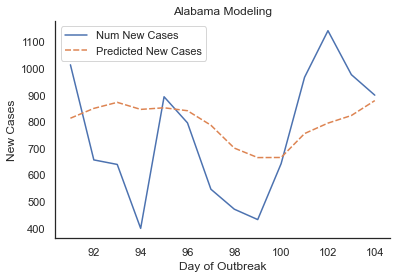

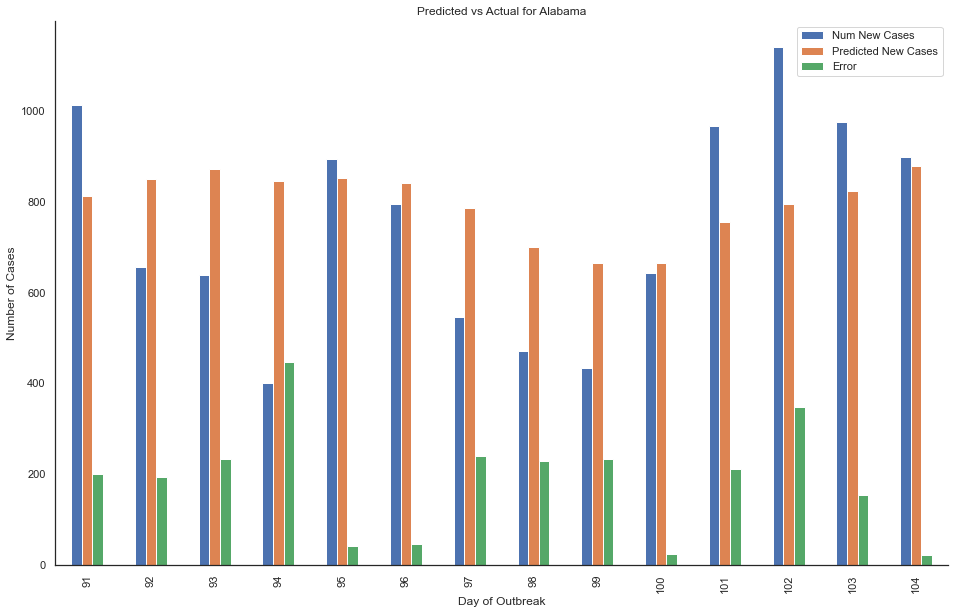

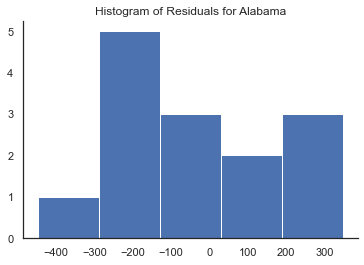

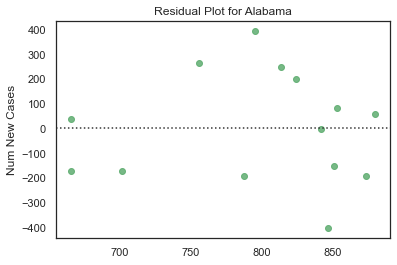

                              Coefficient
Num_New_Cases_7_avg            141.116520
workplace_14_avg                 4.311223
Num_New_Cases_14_avg             0.000000
retail_and_recreation_7_avg      0.000000
transit gps hits_7_avg           0.000000
driving gps hits_7_avg           0.000000
residential_7_avg                0.000000
workplace_7_avg                  0.000000
transit_7_avg                    0.000000
parks_7_avg                     -0.000000
grocery_and_pharmacy_7_avg       0.000000
walking gps hits_14_avg          0.000000
transit gps hits_14_avg          0.000000
driving gps hits_14_avg          0.000000
residential_14_avg              -0.000000
transit_14_avg                   0.000000
parks_14_avg                    -0.000000
grocery_and_pharmacy_14_avg      0.000000
retail_and_recreation_14_avg     0.000000
walking gps hits_7_avg          -0.000000


In [57]:
# Utlize model with best score from GridSearch
model= linear_model.Lasso(alpha= 10)
model.fit(x_train, y_train)
r2_train= model.score(x_train, y_train)
r2_test= model.score(x_test, y_test)
print('R2 TRAIN: {}'.format(r2_train))
print('R2 TEST: {}'.format(r2_test))


y_pred_train= model.predict(x_train)
y_pred_test= model.predict(x_test)
mae_train= mean_absolute_error(y_train, y_pred_train)
mae_test= mean_absolute_error(y_test, y_pred_test)
print('MAE TRAIN: {}'.format(mae_train))
print('MAE TEST: {}'.format(mae_test))

y_test_copy= y_test.copy()
df= y_test_copy.to_frame()
predicted= y_pred_test.tolist()
df['Predicted New Cases']= predicted

#Line plot of the predicted and actual values 
sns.lineplot(data= df)
plt.xlabel('Day of Outbreak')
plt.ylabel('New Cases')
plt.title('{} Modeling'.format(target_state))
sns.despine()
plt.savefig('Images/{} line.png'.format(target_state))
plt.show()

# Add an error colum to the df
df["Error"]= np.abs(df['Num New Cases'] - df['Predicted New Cases'])

# Bar graph of predicted vs actual 
df.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.title('Predicted vs Actual for {}'.format(target_state))
plt.xlabel('Day of Outbreak')
plt.ylabel('Number of Cases')
sns.despine()
plt.grid(b=None)
plt.savefig('Images/{} bar.png'.format(target_state))
plt.show()

# Residuals histogram
residuals= list(y_test - y_pred_test)
plt.hist(x=residuals, bins=5)
plt.title('Histogram of Residuals for {}'.format(target_state))
plt.savefig('Images/{} resid_hist.png'.format(target_state))
sns.despine()
plt.show()

# Residuals scatter plot
sns.residplot(y_pred_test, y_test, color="g")
plt.title('Residual Plot for {}'.format(target_state))
plt.show()


coeff_df = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])  
print(coeff_df.sort_values(by='Coefficient', ascending=False))

state_list.append(target_state)
r2_test_list.append(r2_test)
mae_test_list.append(mae_test)

## Washington

In [58]:
# Extract State from dataset
target_state= 'Washington'
state= full_df[full_df['state'] == target_state]

# Add lagging variables
lagged_df= state.copy()

#Add a 14 and 7 day lag for target variable
# Add a 14 day lag for num new cases
lagged_df['Num_New_Cases_14_avg']= lagged_df['Num New Cases'].rolling(14).mean()

# Add a 7 day lag for num new cases
lagged_df['Num_New_Cases_7_avg']= lagged_df['Num New Cases'].rolling(7).mean()


# Add 14 and 7 day rolling average for mobility markers
# Create a list of all the mobiity markers
mobility_markers= []
for x in lagged_df.columns[2:11]:
    mobility_markers.append(x)

# Create a 14 days running avergae for all mobility markers
for marker in mobility_markers:
    lagged_df['{}_14_avg'.format(marker)]= lagged_df[marker].rolling(14).mean()

# Create a 7 day running avergae for all mobility markers
for marker in mobility_markers:
    lagged_df['{}_7_avg'.format(marker)]= lagged_df[marker].rolling(7).mean()
    
 
lagged_df.dropna(inplace=True)
X= lagged_df.iloc[:,-20:]
y= lagged_df['Num New Cases']

# We want to split the data so that we are using the last 14 days for test
len_data= len(lagged_df)
# Make a point for which we split the data 
split_point= len_data- 14

x_train= X[:split_point]
x_test= X[split_point:]
y_train= y[:split_point]
y_test= y[split_point:]


print('Our X variables will be {}.'.format(list(x_train.columns)))
print('\n')

# scaling data
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print('\n')


# Lasso
alpha= [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid= dict(alpha= alpha)

grid= GridSearchCV(linear_model.Lasso(), param_grid, scoring='neg_mean_absolute_error', cv=5)
grid_result= grid.fit(x_train, y_train)

print('Lasso Regression')
print('Best MAE: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)
print('\n')

alpha= [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid= dict(alpha= alpha)

# Ridge
grid= GridSearchCV(linear_model.Ridge(), param_grid, scoring='neg_mean_absolute_error', cv=5)
grid_result= grid.fit(x_train, y_train)

print('Ridge Regression')
print('Best MAE: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)
print('\n')

#ElasticNet
alpha= [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid= dict(alpha= alpha)

grid= GridSearchCV(linear_model.ElasticNet(), param_grid, scoring='neg_mean_absolute_error', cv=5)
grid_result= grid.fit(x_train, y_train)

print('ElasticNet')
print('Best MAE: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

Our X variables will be ['Num_New_Cases_14_avg', 'Num_New_Cases_7_avg', 'retail_and_recreation_14_avg', 'grocery_and_pharmacy_14_avg', 'parks_14_avg', 'transit_14_avg', 'workplace_14_avg', 'residential_14_avg', 'driving gps hits_14_avg', 'transit gps hits_14_avg', 'walking gps hits_14_avg', 'retail_and_recreation_7_avg', 'grocery_and_pharmacy_7_avg', 'parks_7_avg', 'transit_7_avg', 'workplace_7_avg', 'residential_7_avg', 'driving gps hits_7_avg', 'transit gps hits_7_avg', 'walking gps hits_7_avg'].


(105, 20)
(105,)
(14, 20)
(14,)


Lasso Regression
Best MAE:  -98.19521706539228
Best Params:  {'alpha': 1}


Ridge Regression
Best MAE:  -99.93950520043164
Best Params:  {'alpha': 1}


ElasticNet
Best MAE:  -107.11264765782043
Best Params:  {'alpha': 0.01}


R2 TRAIN: 0.5211054246820058
R2 TEST: 0.1779798670675572
MAE TRAIN: 86.73421901894054
MAE TEST: 86.89537958201272


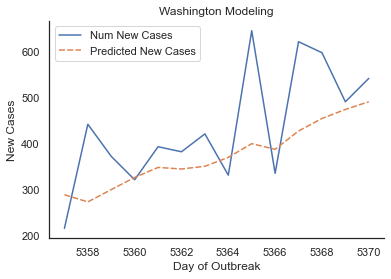

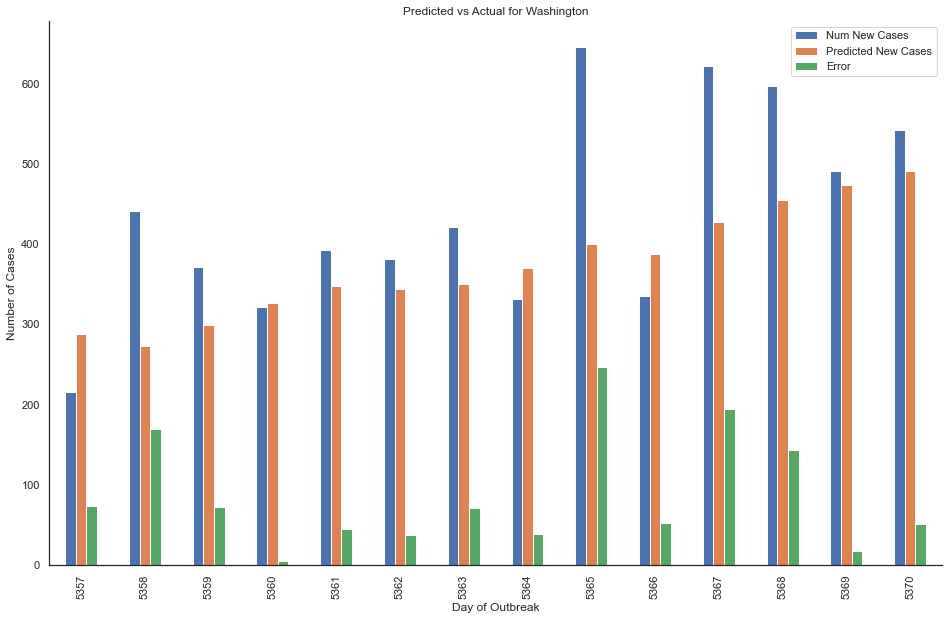

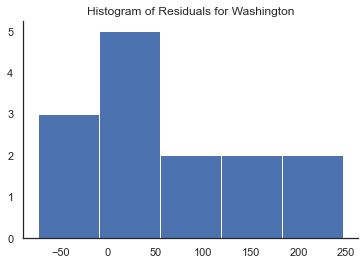

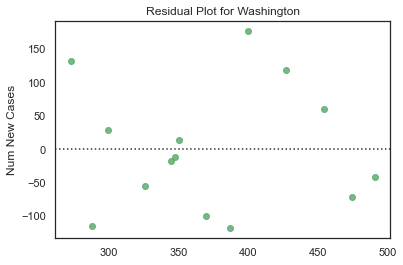

                              Coefficient
Num_New_Cases_7_avg            166.835407
residential_7_avg               31.208746
grocery_and_pharmacy_14_avg     24.905200
driving gps hits_14_avg          1.798407
walking gps hits_14_avg          0.000000
retail_and_recreation_7_avg     -0.000000
transit gps hits_7_avg          -0.000000
driving gps hits_7_avg           0.000000
workplace_7_avg                 -0.000000
transit_7_avg                    0.000000
grocery_and_pharmacy_7_avg      -0.000000
walking gps hits_7_avg          -0.000000
transit gps hits_14_avg         -0.000000
residential_14_avg              -0.000000
workplace_14_avg                 0.000000
transit_14_avg                   0.000000
parks_14_avg                     0.000000
retail_and_recreation_14_avg     0.000000
parks_7_avg                     -4.133333
Num_New_Cases_14_avg           -57.782755


In [59]:
# Utlize model with best score from GridSearch
model= linear_model.Lasso(alpha= 1)
model.fit(x_train, y_train)
r2_train= model.score(x_train, y_train)
r2_test= model.score(x_test, y_test)
print('R2 TRAIN: {}'.format(r2_train))
print('R2 TEST: {}'.format(r2_test))


y_pred_train= model.predict(x_train)
y_pred_test= model.predict(x_test)
mae_train= mean_absolute_error(y_train, y_pred_train)
mae_test= mean_absolute_error(y_test, y_pred_test)
print('MAE TRAIN: {}'.format(mae_train))
print('MAE TEST: {}'.format(mae_test))

y_test_copy= y_test.copy()
df= y_test_copy.to_frame()
predicted= y_pred_test.tolist()
df['Predicted New Cases']= predicted

#Line plot of the predicted and actual values 
sns.lineplot(data= df)
plt.xlabel('Day of Outbreak')
plt.ylabel('New Cases')
plt.title('{} Modeling'.format(target_state))
sns.despine()
plt.savefig('Images/{} line.png'.format(target_state))
plt.show()

# Add an error colum to the df
df["Error"]= np.abs(df['Num New Cases'] - df['Predicted New Cases'])

# Bar graph of predicted vs actual 
df.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.title('Predicted vs Actual for {}'.format(target_state))
plt.xlabel('Day of Outbreak')
plt.ylabel('Number of Cases')
sns.despine()
plt.grid(b=None)
plt.savefig('Images/{} bar.png'.format(target_state))
plt.show()

# Residuals histogram
residuals= list(y_test - y_pred_test)
plt.hist(x=residuals, bins=5)
plt.title('Histogram of Residuals for {}'.format(target_state))
plt.savefig('Images/{} resid_hist.png'.format(target_state))
sns.despine()
plt.show()

# Residuals scatter plot
sns.residplot(y_pred_test, y_test, color="g")
plt.title('Residual Plot for {}'.format(target_state))
plt.show()


coeff_df = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])  
print(coeff_df.sort_values(by='Coefficient', ascending=False))

state_list.append(target_state)
r2_test_list.append(r2_test)
mae_test_list.append(mae_test)

## Oregon

In [60]:
# Extract State from dataset
target_state= 'Oregon'
state= full_df[full_df['state'] == target_state]

# Add lagging variables
lagged_df= state.copy()

#Add a 14 and 7 day lag for target variable
# Add a 14 day lag for num new cases
lagged_df['Num_New_Cases_14_avg']= lagged_df['Num New Cases'].rolling(14).mean()

# Add a 7 day lag for num new cases
lagged_df['Num_New_Cases_7_avg']= lagged_df['Num New Cases'].rolling(7).mean()


# Add 14 and 7 day rolling average for mobility markers
# Create a list of all the mobiity markers
mobility_markers= []
for x in lagged_df.columns[2:11]:
    mobility_markers.append(x)

# Create a 14 days running avergae for all mobility markers
for marker in mobility_markers:
    lagged_df['{}_14_avg'.format(marker)]= lagged_df[marker].rolling(14).mean()

# Create a 7 day running avergae for all mobility markers
for marker in mobility_markers:
    lagged_df['{}_7_avg'.format(marker)]= lagged_df[marker].rolling(7).mean()
    
 
lagged_df.dropna(inplace=True)
X= lagged_df.iloc[:,-20:]
y= lagged_df['Num New Cases']

# We want to split the data so that we are using the last 14 days for test
len_data= len(lagged_df)
# Make a point for which we split the data 
split_point= len_data- 14

x_train= X[:split_point]
x_test= X[split_point:]
y_train= y[:split_point]
y_test= y[split_point:]


print('Our X variables will be {}.'.format(list(x_train.columns)))
print('\n')

# scaling data
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print('\n')


# Lasso
alpha= [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid= dict(alpha= alpha)

grid= GridSearchCV(linear_model.Lasso(), param_grid, scoring='neg_mean_absolute_error', cv=5)
grid_result= grid.fit(x_train, y_train)

print('Lasso Regression')
print('Best MAE: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)
print('\n')

alpha= [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid= dict(alpha= alpha)

# Ridge
grid= GridSearchCV(linear_model.Ridge(), param_grid, scoring='neg_mean_absolute_error', cv=5)
grid_result= grid.fit(x_train, y_train)

print('Ridge Regression')
print('Best MAE: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)
print('\n')

#ElasticNet
alpha= [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid= dict(alpha= alpha)

grid= GridSearchCV(linear_model.ElasticNet(), param_grid, scoring='neg_mean_absolute_error', cv=5)
grid_result= grid.fit(x_train, y_train)

print('ElasticNet')
print('Best MAE: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

Our X variables will be ['Num_New_Cases_14_avg', 'Num_New_Cases_7_avg', 'retail_and_recreation_14_avg', 'grocery_and_pharmacy_14_avg', 'parks_14_avg', 'transit_14_avg', 'workplace_14_avg', 'residential_14_avg', 'driving gps hits_14_avg', 'transit gps hits_14_avg', 'walking gps hits_14_avg', 'retail_and_recreation_7_avg', 'grocery_and_pharmacy_7_avg', 'parks_7_avg', 'transit_7_avg', 'workplace_7_avg', 'residential_7_avg', 'driving gps hits_7_avg', 'transit gps hits_7_avg', 'walking gps hits_7_avg'].


(92, 20)
(92,)
(14, 20)
(14,)


Lasso Regression
Best MAE:  -18.540376725543396
Best Params:  {'alpha': 1}


Ridge Regression
Best MAE:  -22.43454706811094
Best Params:  {'alpha': 1}


ElasticNet
Best MAE:  -21.87272799165602
Best Params:  {'alpha': 0.1}


R2 TRAIN: 0.6486892271406288
R2 TEST: 0.13877392146165968
MAE TRAIN: 14.225460003755341
MAE TEST: 57.128519891853266


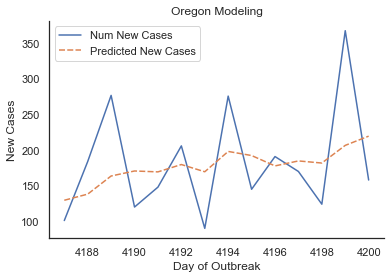

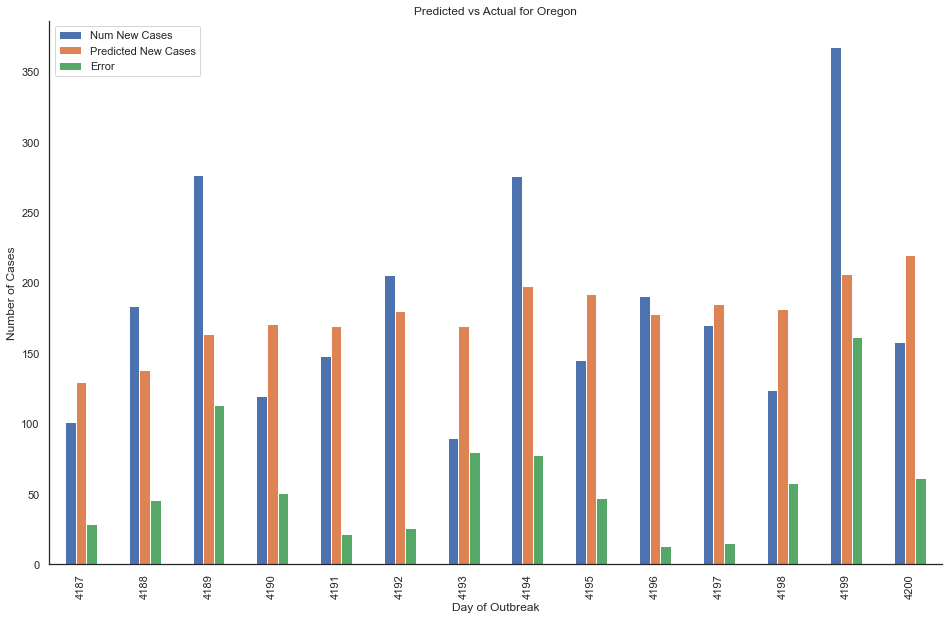

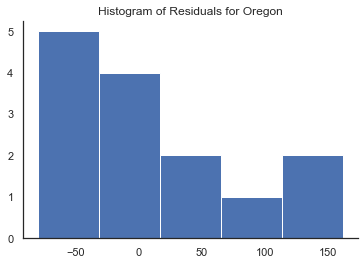

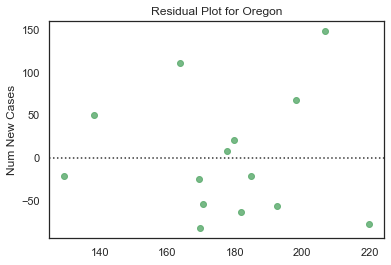

                              Coefficient
Num_New_Cases_7_avg             30.284427
parks_14_avg                     4.702802
residential_7_avg                0.960626
walking gps hits_14_avg          0.000000
retail_and_recreation_7_avg     -0.000000
transit gps hits_7_avg          -0.000000
driving gps hits_7_avg          -0.000000
workplace_7_avg                 -0.000000
transit_7_avg                   -0.000000
parks_7_avg                      0.000000
grocery_and_pharmacy_7_avg      -0.000000
walking gps hits_7_avg          -0.000000
transit gps hits_14_avg          0.000000
driving gps hits_14_avg          0.000000
residential_14_avg               0.000000
workplace_14_avg                -0.000000
transit_14_avg                   0.000000
grocery_and_pharmacy_14_avg     -0.000000
retail_and_recreation_14_avg     0.000000
Num_New_Cases_14_avg            -5.898143


In [61]:
# Utlize model with best score from GridSearch
model= linear_model.Lasso(alpha= 1)
model.fit(x_train, y_train)
r2_train= model.score(x_train, y_train)
r2_test= model.score(x_test, y_test)
print('R2 TRAIN: {}'.format(r2_train))
print('R2 TEST: {}'.format(r2_test))


y_pred_train= model.predict(x_train)
y_pred_test= model.predict(x_test)
mae_train= mean_absolute_error(y_train, y_pred_train)
mae_test= mean_absolute_error(y_test, y_pred_test)
print('MAE TRAIN: {}'.format(mae_train))
print('MAE TEST: {}'.format(mae_test))

y_test_copy= y_test.copy()
df= y_test_copy.to_frame()
predicted= y_pred_test.tolist()
df['Predicted New Cases']= predicted

#Line plot of the predicted and actual values 
sns.lineplot(data= df)
plt.xlabel('Day of Outbreak')
plt.ylabel('New Cases')
plt.title('{} Modeling'.format(target_state))
sns.despine()
plt.savefig('Images/{} line.png'.format(target_state))
plt.show()

# Add an error colum to the df
df["Error"]= np.abs(df['Num New Cases'] - df['Predicted New Cases'])

# Bar graph of predicted vs actual 
df.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.title('Predicted vs Actual for {}'.format(target_state))
plt.xlabel('Day of Outbreak')
plt.ylabel('Number of Cases')
sns.despine()
plt.grid(b=None)
plt.savefig('Images/{} bar.png'.format(target_state))
plt.show()

# Residuals histogram
residuals= list(y_test - y_pred_test)
plt.hist(x=residuals, bins=5)
plt.title('Histogram of Residuals for {}'.format(target_state))
plt.savefig('Images/{} resid_hist.png'.format(target_state))
sns.despine()
plt.show()

# Residuals scatter plot
sns.residplot(y_pred_test, y_test, color="g")
plt.title('Residual Plot for {}'.format(target_state))
plt.show()


coeff_df = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])  
print(coeff_df.sort_values(by='Coefficient', ascending=False))

state_list.append(target_state)
r2_test_list.append(r2_test)
mae_test_list.append(mae_test)

## Ohio

In [62]:
# Extract State from dataset
target_state= 'Ohio'
state= full_df[full_df['state'] == target_state]

# Add lagging variables
lagged_df= state.copy()

#Add a 14 and 7 day lag for target variable
# Add a 14 day lag for num new cases
lagged_df['Num_New_Cases_14_avg']= lagged_df['Num New Cases'].rolling(14).mean()

# Add a 7 day lag for num new cases
lagged_df['Num_New_Cases_7_avg']= lagged_df['Num New Cases'].rolling(7).mean()


# Add 14 and 7 day rolling average for mobility markers
# Create a list of all the mobiity markers
mobility_markers= []
for x in lagged_df.columns[2:11]:
    mobility_markers.append(x)

# Create a 14 days running avergae for all mobility markers
for marker in mobility_markers:
    lagged_df['{}_14_avg'.format(marker)]= lagged_df[marker].rolling(14).mean()

# Create a 7 day running avergae for all mobility markers
for marker in mobility_markers:
    lagged_df['{}_7_avg'.format(marker)]= lagged_df[marker].rolling(7).mean()
    
 
lagged_df.dropna(inplace=True)
X= lagged_df.iloc[:,-20:]
y= lagged_df['Num New Cases']

# We want to split the data so that we are using the last 14 days for test
len_data= len(lagged_df)
# Make a point for which we split the data 
split_point= len_data- 14

x_train= X[:split_point]
x_test= X[split_point:]
y_train= y[:split_point]
y_test= y[split_point:]


print('Our X variables will be {}.'.format(list(x_train.columns)))
print('\n')

# scaling data
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print('\n')


# Lasso
alpha= [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid= dict(alpha= alpha)

grid= GridSearchCV(linear_model.Lasso(), param_grid, scoring='neg_mean_absolute_error', cv=5)
grid_result= grid.fit(x_train, y_train)

print('Lasso Regression')
print('Best MAE: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)
print('\n')

alpha= [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid= dict(alpha= alpha)

# Ridge
grid= GridSearchCV(linear_model.Ridge(), param_grid, scoring='neg_mean_absolute_error', cv=5)
grid_result= grid.fit(x_train, y_train)

print('Ridge Regression')
print('Best MAE: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)
print('\n')

#ElasticNet
alpha= [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid= dict(alpha= alpha)

grid= GridSearchCV(linear_model.ElasticNet(), param_grid, scoring='neg_mean_absolute_error', cv=5)
grid_result= grid.fit(x_train, y_train)

print('ElasticNet')
print('Best MAE: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

Our X variables will be ['Num_New_Cases_14_avg', 'Num_New_Cases_7_avg', 'retail_and_recreation_14_avg', 'grocery_and_pharmacy_14_avg', 'parks_14_avg', 'transit_14_avg', 'workplace_14_avg', 'residential_14_avg', 'driving gps hits_14_avg', 'transit gps hits_14_avg', 'walking gps hits_14_avg', 'retail_and_recreation_7_avg', 'grocery_and_pharmacy_7_avg', 'parks_7_avg', 'transit_7_avg', 'workplace_7_avg', 'residential_7_avg', 'driving gps hits_7_avg', 'transit gps hits_7_avg', 'walking gps hits_7_avg'].


(82, 20)
(82,)
(14, 20)
(14,)


Lasso Regression
Best MAE:  -144.09640674919748
Best Params:  {'alpha': 10}


Ridge Regression
Best MAE:  -143.55009990625334
Best Params:  {'alpha': 10}


ElasticNet
Best MAE:  -143.56439260693932
Best Params:  {'alpha': 1}


R2 TRAIN: 0.45162733875740957
R2 TEST: -0.5331227053386398
MAE TRAIN: 108.34036694124762
MAE TEST: 197.98063343680093


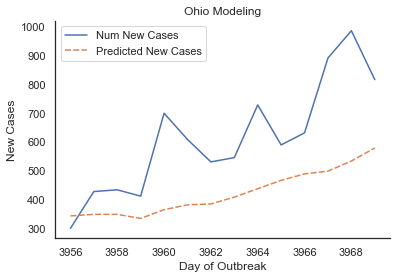

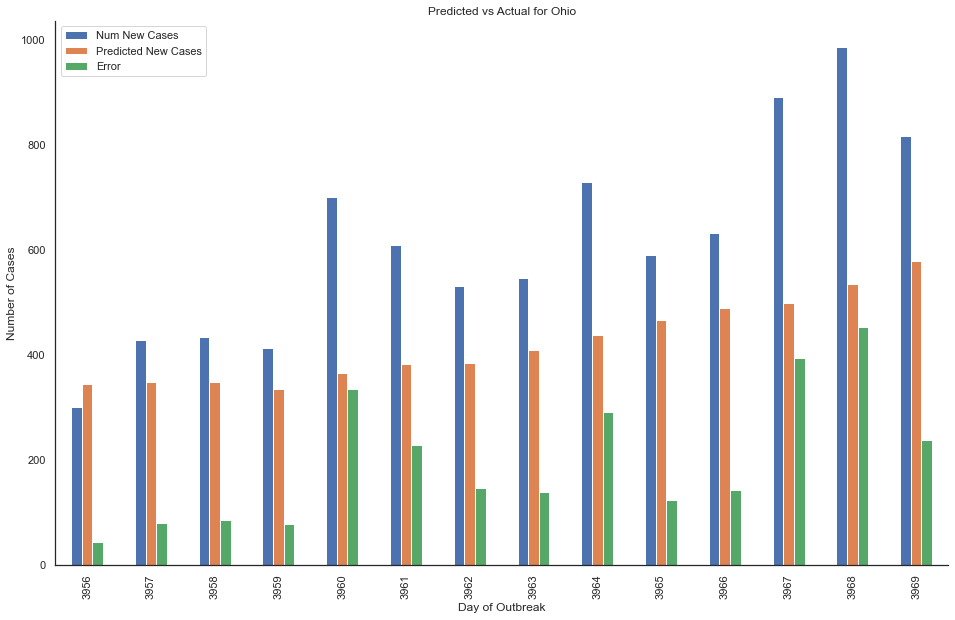

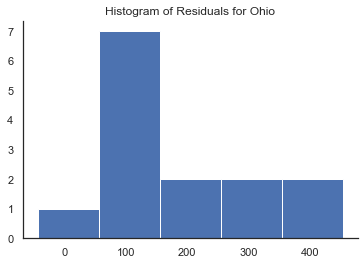

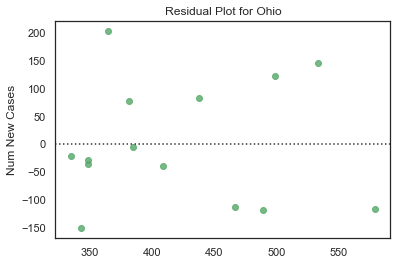

                              Coefficient
Num_New_Cases_7_avg             90.335091
Num_New_Cases_14_avg            30.761715
retail_and_recreation_7_avg     25.988021
driving gps hits_14_avg         23.053856
driving gps hits_7_avg          22.400958
residential_7_avg               21.129730
walking gps hits_14_avg         19.982454
parks_14_avg                    18.635369
grocery_and_pharmacy_14_avg     12.217376
retail_and_recreation_14_avg    10.686618
grocery_and_pharmacy_7_avg       5.787827
residential_14_avg               2.779943
transit_14_avg                   2.154723
transit_7_avg                   -1.334086
transit gps hits_14_avg         -5.435673
walking gps hits_7_avg          -8.521522
workplace_7_avg                -12.730019
transit gps hits_7_avg         -23.448244
workplace_14_avg               -44.542369
parks_7_avg                    -69.825748


In [63]:
# Utlize model with best score from GridSearch
model= linear_model.Ridge(alpha= 10)
model.fit(x_train, y_train)
r2_train= model.score(x_train, y_train)
r2_test= model.score(x_test, y_test)
print('R2 TRAIN: {}'.format(r2_train))
print('R2 TEST: {}'.format(r2_test))


y_pred_train= model.predict(x_train)
y_pred_test= model.predict(x_test)
mae_train= mean_absolute_error(y_train, y_pred_train)
mae_test= mean_absolute_error(y_test, y_pred_test)
print('MAE TRAIN: {}'.format(mae_train))
print('MAE TEST: {}'.format(mae_test))

y_test_copy= y_test.copy()
df= y_test_copy.to_frame()
predicted= y_pred_test.tolist()
df['Predicted New Cases']= predicted

#Line plot of the predicted and actual values 
sns.lineplot(data= df)
plt.xlabel('Day of Outbreak')
plt.ylabel('New Cases')
plt.title('{} Modeling'.format(target_state))
sns.despine()
plt.savefig('Images/{} line.png'.format(target_state))
plt.show()

# Add an error colum to the df
df["Error"]= np.abs(df['Num New Cases'] - df['Predicted New Cases'])

# Bar graph of predicted vs actual 
df.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.title('Predicted vs Actual for {}'.format(target_state))
plt.xlabel('Day of Outbreak')
plt.ylabel('Number of Cases')
sns.despine()
plt.grid(b=None)
plt.savefig('Images/{} bar.png'.format(target_state))
plt.show()

# Residuals histogram
residuals= list(y_test - y_pred_test)
plt.hist(x=residuals, bins=5)
plt.title('Histogram of Residuals for {}'.format(target_state))
plt.savefig('Images/{} resid_hist.png'.format(target_state))
sns.despine()
plt.show()

# Residuals scatter plot
sns.residplot(y_pred_test, y_test, color="g")
plt.title('Residual Plot for {}'.format(target_state))
plt.show()


coeff_df = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])  
print(coeff_df.sort_values(by='Coefficient', ascending=False))

state_list.append(target_state)
r2_test_list.append(r2_test)
mae_test_list.append(mae_test)

## Florida

In [64]:
# Extract State from dataset
target_state= 'Florida'
state= full_df[full_df['state'] == target_state]

# Add lagging variables
lagged_df= state.copy()

#Add a 14 and 7 day lag for target variable
# Add a 14 day lag for num new cases
lagged_df['Num_New_Cases_14_avg']= lagged_df['Num New Cases'].rolling(14).mean()

# Add a 7 day lag for num new cases
lagged_df['Num_New_Cases_7_avg']= lagged_df['Num New Cases'].rolling(7).mean()


# Add 14 and 7 day rolling average for mobility markers
# Create a list of all the mobiity markers
mobility_markers= []
for x in lagged_df.columns[2:11]:
    mobility_markers.append(x)

# Create a 14 days running avergae for all mobility markers
for marker in mobility_markers:
    lagged_df['{}_14_avg'.format(marker)]= lagged_df[marker].rolling(14).mean()

# Create a 7 day running avergae for all mobility markers
for marker in mobility_markers:
    lagged_df['{}_7_avg'.format(marker)]= lagged_df[marker].rolling(7).mean()
    
 
lagged_df.dropna(inplace=True)
X= lagged_df.iloc[:,-20:]
y= lagged_df['Num New Cases']

# We want to split the data so that we are using the last 14 days for test
len_data= len(lagged_df)
# Make a point for which we split the data 
split_point= len_data- 14

x_train= X[:split_point]
x_test= X[split_point:]
y_train= y[:split_point]
y_test= y[split_point:]


print('Our X variables will be {}.'.format(list(x_train.columns)))
print('\n')

# scaling data
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print('\n')


# Lasso
alpha= [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid= dict(alpha= alpha)

grid= GridSearchCV(linear_model.Lasso(), param_grid, scoring='neg_mean_absolute_error', cv=5)
grid_result= grid.fit(x_train, y_train)

print('Lasso Regression')
print('Best MAE: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)
print('\n')

alpha= [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid= dict(alpha= alpha)

# Ridge
grid= GridSearchCV(linear_model.Ridge(), param_grid, scoring='neg_mean_absolute_error', cv=5)
grid_result= grid.fit(x_train, y_train)

print('Ridge Regression')
print('Best MAE: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)
print('\n')

#ElasticNet
alpha= [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid= dict(alpha= alpha)

grid= GridSearchCV(linear_model.ElasticNet(), param_grid, scoring='neg_mean_absolute_error', cv=5)
grid_result= grid.fit(x_train, y_train)

print('ElasticNet')
print('Best MAE: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

Our X variables will be ['Num_New_Cases_14_avg', 'Num_New_Cases_7_avg', 'retail_and_recreation_14_avg', 'grocery_and_pharmacy_14_avg', 'parks_14_avg', 'transit_14_avg', 'workplace_14_avg', 'residential_14_avg', 'driving gps hits_14_avg', 'transit gps hits_14_avg', 'walking gps hits_14_avg', 'retail_and_recreation_7_avg', 'grocery_and_pharmacy_7_avg', 'parks_7_avg', 'transit_7_avg', 'workplace_7_avg', 'residential_7_avg', 'driving gps hits_7_avg', 'transit gps hits_7_avg', 'walking gps hits_7_avg'].


(90, 20)
(90,)
(14, 20)
(14,)


Lasso Regression
Best MAE:  -222.67403251767365
Best Params:  {'alpha': 10}


Ridge Regression
Best MAE:  -306.01815287528973
Best Params:  {'alpha': 10}


ElasticNet
Best MAE:  -314.5230734121253
Best Params:  {'alpha': 0.1}


R2 TRAIN: 0.6916967296391558
R2 TEST: 0.7410664783692937
MAE TRAIN: 181.631435380581
MAE TEST: 771.0280574608289


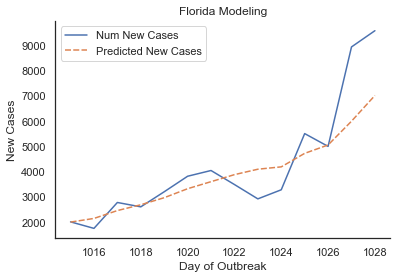

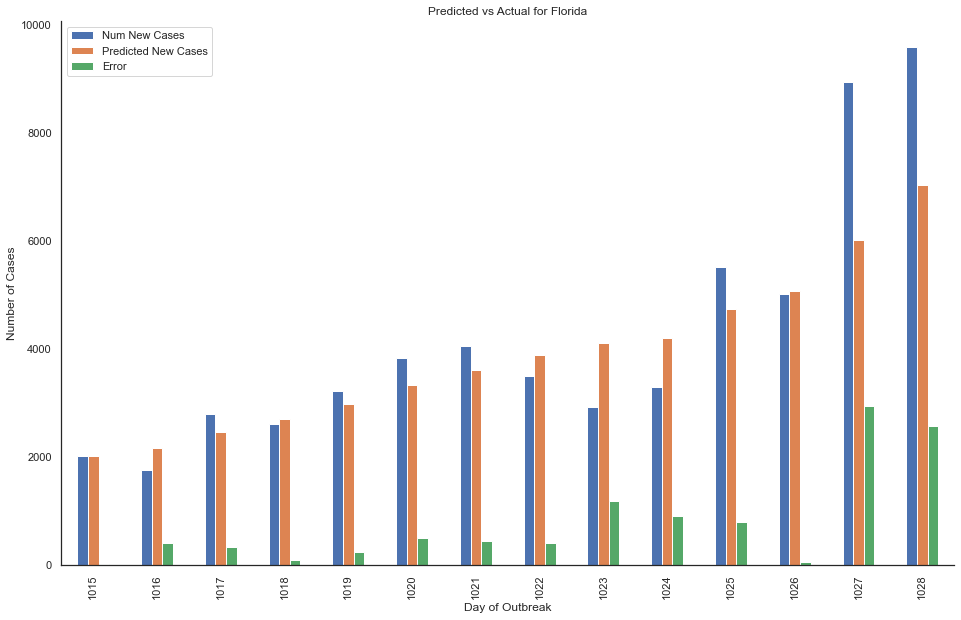

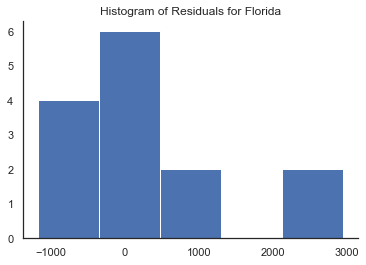

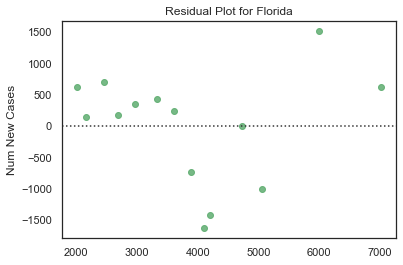

                              Coefficient
Num_New_Cases_7_avg            427.843047
grocery_and_pharmacy_14_avg    115.953783
Num_New_Cases_14_avg            -0.000000
retail_and_recreation_7_avg     -0.000000
transit gps hits_7_avg          -0.000000
driving gps hits_7_avg          -0.000000
residential_7_avg                0.000000
workplace_7_avg                 -0.000000
transit_7_avg                   -0.000000
parks_7_avg                      0.000000
grocery_and_pharmacy_7_avg      -0.000000
walking gps hits_14_avg         -0.000000
transit gps hits_14_avg         -0.000000
driving gps hits_14_avg          0.000000
residential_14_avg              -0.000000
workplace_14_avg                 0.000000
transit_14_avg                   0.000000
parks_14_avg                     0.000000
retail_and_recreation_14_avg     0.000000
walking gps hits_7_avg          -0.000000


In [65]:
# Utlize model with best score from GridSearch
model= linear_model.Lasso(alpha= 10)
model.fit(x_train, y_train)
r2_train= model.score(x_train, y_train)
r2_test= model.score(x_test, y_test)
print('R2 TRAIN: {}'.format(r2_train))
print('R2 TEST: {}'.format(r2_test))


y_pred_train= model.predict(x_train)
y_pred_test= model.predict(x_test)
mae_train= mean_absolute_error(y_train, y_pred_train)
mae_test= mean_absolute_error(y_test, y_pred_test)
print('MAE TRAIN: {}'.format(mae_train))
print('MAE TEST: {}'.format(mae_test))

y_test_copy= y_test.copy()
df= y_test_copy.to_frame()
predicted= y_pred_test.tolist()
df['Predicted New Cases']= predicted

#Line plot of the predicted and actual values 
sns.lineplot(data= df)
plt.xlabel('Day of Outbreak')
plt.ylabel('New Cases')
plt.title('{} Modeling'.format(target_state))
sns.despine()
plt.savefig('Images/{} line.png'.format(target_state))
plt.show()

# Add an error colum to the df
df["Error"]= np.abs(df['Num New Cases'] - df['Predicted New Cases'])

# Bar graph of predicted vs actual 
df.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.title('Predicted vs Actual for {}'.format(target_state))
plt.xlabel('Day of Outbreak')
plt.ylabel('Number of Cases')
sns.despine()
plt.grid(b=None)
plt.savefig('Images/{} bar.png'.format(target_state))
plt.show()

# Residuals histogram
residuals= list(y_test - y_pred_test)
plt.hist(x=residuals, bins=5)
plt.title('Histogram of Residuals for {}'.format(target_state))
plt.savefig('Images/{} resid_hist.png'.format(target_state))
sns.despine()
plt.show()

# Residuals scatter plot
sns.residplot(y_pred_test, y_test, color="g")
plt.title('Residual Plot for {}'.format(target_state))
plt.show()


coeff_df = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])  
print(coeff_df.sort_values(by='Coefficient', ascending=False))

state_list.append(target_state)
r2_test_list.append(r2_test)
mae_test_list.append(mae_test)

## Colorado

In [66]:
# Extract State from dataset
target_state= 'Colorado'
state= full_df[full_df['state'] == target_state]

# Add lagging variables
lagged_df= state.copy()

#Add a 14 and 7 day lag for target variable
# Add a 14 day lag for num new cases
lagged_df['Num_New_Cases_14_avg']= lagged_df['Num New Cases'].rolling(14).mean()

# Add a 7 day lag for num new cases
lagged_df['Num_New_Cases_7_avg']= lagged_df['Num New Cases'].rolling(7).mean()


# Add 14 and 7 day rolling average for mobility markers
# Create a list of all the mobiity markers
mobility_markers= []
for x in lagged_df.columns[2:11]:
    mobility_markers.append(x)

# Create a 14 days running avergae for all mobility markers
for marker in mobility_markers:
    lagged_df['{}_14_avg'.format(marker)]= lagged_df[marker].rolling(14).mean()

# Create a 7 day running avergae for all mobility markers
for marker in mobility_markers:
    lagged_df['{}_7_avg'.format(marker)]= lagged_df[marker].rolling(7).mean()
    
 
lagged_df.dropna(inplace=True)
X= lagged_df.iloc[:,-20:]
y= lagged_df['Num New Cases']

# We want to split the data so that we are using the last 14 days for test
len_data= len(lagged_df)
# Make a point for which we split the data 
split_point= len_data- 14

x_train= X[:split_point]
x_test= X[split_point:]
y_train= y[:split_point]
y_test= y[split_point:]


print('Our X variables will be {}.'.format(list(x_train.columns)))
print('\n')

# scaling data
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print('\n')


# Lasso
alpha= [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid= dict(alpha= alpha)

grid= GridSearchCV(linear_model.Lasso(), param_grid, scoring='neg_mean_absolute_error', cv=5)
grid_result= grid.fit(x_train, y_train)

print('Lasso Regression')
print('Best MAE: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)
print('\n')

alpha= [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid= dict(alpha= alpha)

# Ridge
grid= GridSearchCV(linear_model.Ridge(), param_grid, scoring='neg_mean_absolute_error', cv=5)
grid_result= grid.fit(x_train, y_train)

print('Ridge Regression')
print('Best MAE: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)
print('\n')

#ElasticNet
alpha= [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid= dict(alpha= alpha)

grid= GridSearchCV(linear_model.ElasticNet(), param_grid, scoring='neg_mean_absolute_error', cv=5)
grid_result= grid.fit(x_train, y_train)

print('ElasticNet')
print('Best MAE: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

Our X variables will be ['Num_New_Cases_14_avg', 'Num_New_Cases_7_avg', 'retail_and_recreation_14_avg', 'grocery_and_pharmacy_14_avg', 'parks_14_avg', 'transit_14_avg', 'workplace_14_avg', 'residential_14_avg', 'driving gps hits_14_avg', 'transit gps hits_14_avg', 'walking gps hits_14_avg', 'retail_and_recreation_7_avg', 'grocery_and_pharmacy_7_avg', 'parks_7_avg', 'transit_7_avg', 'workplace_7_avg', 'residential_7_avg', 'driving gps hits_7_avg', 'transit gps hits_7_avg', 'walking gps hits_7_avg'].


(86, 20)
(86,)
(14, 20)
(14,)


Lasso Regression
Best MAE:  -79.03087075779922
Best Params:  {'alpha': 10}


Ridge Regression
Best MAE:  -96.55484226491501
Best Params:  {'alpha': 100}


ElasticNet
Best MAE:  -86.25705068974212
Best Params:  {'alpha': 1}


R2 TRAIN: 0.5327849039549667
R2 TEST: 0.18177351480619997
MAE TRAIN: 68.29267391426669
MAE TEST: 44.681296812624204


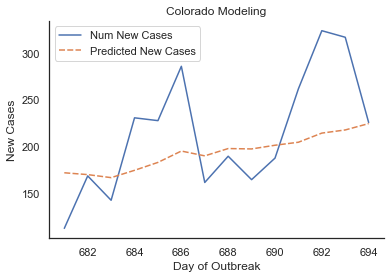

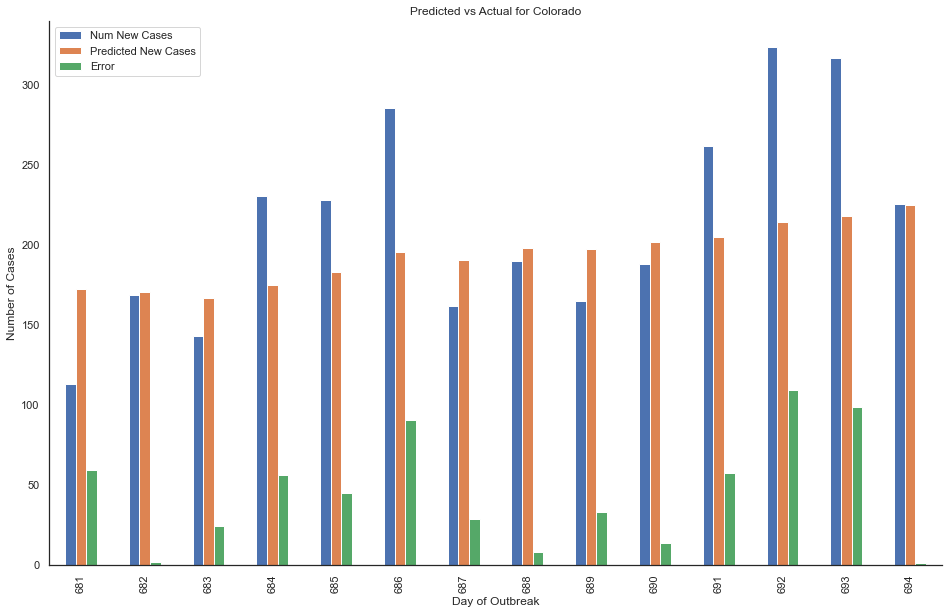

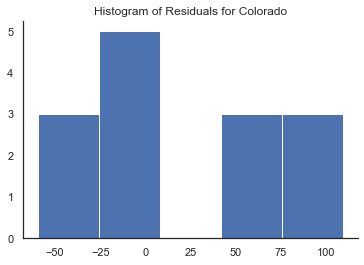

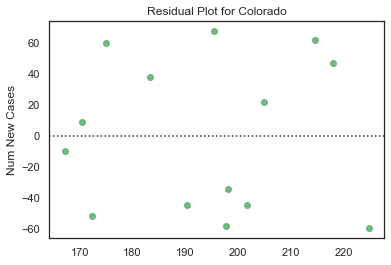

                              Coefficient
Num_New_Cases_7_avg             90.385871
Num_New_Cases_14_avg             0.000000
transit gps hits_7_avg          -0.000000
driving gps hits_7_avg          -0.000000
residential_7_avg                0.000000
transit_7_avg                   -0.000000
parks_7_avg                     -0.000000
grocery_and_pharmacy_7_avg      -0.000000
retail_and_recreation_7_avg     -0.000000
walking gps hits_14_avg         -0.000000
transit gps hits_14_avg         -0.000000
driving gps hits_14_avg         -0.000000
residential_14_avg               0.000000
workplace_14_avg                -0.000000
transit_14_avg                  -0.000000
grocery_and_pharmacy_14_avg     -0.000000
retail_and_recreation_14_avg    -0.000000
walking gps hits_7_avg          -0.000000
parks_14_avg                    -9.328784
workplace_7_avg                -15.946966


In [67]:
# Utlize model with best score from GridSearch
model= linear_model.Lasso(alpha= 10)
model.fit(x_train, y_train)
r2_train= model.score(x_train, y_train)
r2_test= model.score(x_test, y_test)
print('R2 TRAIN: {}'.format(r2_train))
print('R2 TEST: {}'.format(r2_test))


y_pred_train= model.predict(x_train)
y_pred_test= model.predict(x_test)
mae_train= mean_absolute_error(y_train, y_pred_train)
mae_test= mean_absolute_error(y_test, y_pred_test)
print('MAE TRAIN: {}'.format(mae_train))
print('MAE TEST: {}'.format(mae_test))

y_test_copy= y_test.copy()
df= y_test_copy.to_frame()
predicted= y_pred_test.tolist()
df['Predicted New Cases']= predicted

#Line plot of the predicted and actual values 
sns.lineplot(data= df)
plt.xlabel('Day of Outbreak')
plt.ylabel('New Cases')
plt.title('{} Modeling'.format(target_state))
sns.despine()
plt.savefig('Images/{} line.png'.format(target_state))
plt.show()

# Add an error colum to the df
df["Error"]= np.abs(df['Num New Cases'] - df['Predicted New Cases'])

# Bar graph of predicted vs actual 
df.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.title('Predicted vs Actual for {}'.format(target_state))
plt.xlabel('Day of Outbreak')
plt.ylabel('Number of Cases')
sns.despine()
plt.grid(b=None)
plt.savefig('Images/{} bar.png'.format(target_state))
plt.show()

# Residuals histogram
residuals= list(y_test - y_pred_test)
plt.hist(x=residuals, bins=5)
plt.title('Histogram of Residuals for {}'.format(target_state))
plt.savefig('Images/{} resid_hist.png'.format(target_state))
sns.despine()
plt.show()

# Residuals scatter plot
sns.residplot(y_pred_test, y_test, color="g")
plt.title('Residual Plot for {}'.format(target_state))
plt.show()


coeff_df = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])  
print(coeff_df.sort_values(by='Coefficient', ascending=False))

state_list.append(target_state)
r2_test_list.append(r2_test)
mae_test_list.append(mae_test)

## Minnesota

In [68]:
# Extract State from dataset
target_state= 'Minnesota'
state= full_df[full_df['state'] == target_state]

# Add lagging variables
lagged_df= state.copy()

#Add a 14 and 7 day lag for target variable
# Add a 14 day lag for num new cases
lagged_df['Num_New_Cases_14_avg']= lagged_df['Num New Cases'].rolling(14).mean()

# Add a 7 day lag for num new cases
lagged_df['Num_New_Cases_7_avg']= lagged_df['Num New Cases'].rolling(7).mean()


# Add 14 and 7 day rolling average for mobility markers
# Create a list of all the mobiity markers
mobility_markers= []
for x in lagged_df.columns[2:11]:
    mobility_markers.append(x)

# Create a 14 days running avergae for all mobility markers
for marker in mobility_markers:
    lagged_df['{}_14_avg'.format(marker)]= lagged_df[marker].rolling(14).mean()

# Create a 7 day running avergae for all mobility markers
for marker in mobility_markers:
    lagged_df['{}_7_avg'.format(marker)]= lagged_df[marker].rolling(7).mean()
    
 
lagged_df.dropna(inplace=True)
X= lagged_df.iloc[:,-20:]
y= lagged_df['Num New Cases']

# We want to split the data so that we are using the last 14 days for test
len_data= len(lagged_df)
# Make a point for which we split the data 
split_point= len_data- 14

x_train= X[:split_point]
x_test= X[split_point:]
y_train= y[:split_point]
y_test= y[split_point:]


print('Our X variables will be {}.'.format(list(x_train.columns)))
print('\n')

# scaling data
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print('\n')


# Lasso
alpha= [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid= dict(alpha= alpha)

grid= GridSearchCV(linear_model.Lasso(), param_grid, scoring='neg_mean_absolute_error', cv=5)
grid_result= grid.fit(x_train, y_train)

print('Lasso Regression')
print('Best MAE: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)
print('\n')

alpha= [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid= dict(alpha= alpha)

# Ridge
grid= GridSearchCV(linear_model.Ridge(), param_grid, scoring='neg_mean_absolute_error', cv=5)
grid_result= grid.fit(x_train, y_train)

print('Ridge Regression')
print('Best MAE: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)
print('\n')

#ElasticNet
alpha= [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid= dict(alpha= alpha)

grid= GridSearchCV(linear_model.ElasticNet(), param_grid, scoring='neg_mean_absolute_error', cv=5)
grid_result= grid.fit(x_train, y_train)

print('ElasticNet')
print('Best MAE: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

Our X variables will be ['Num_New_Cases_14_avg', 'Num_New_Cases_7_avg', 'retail_and_recreation_14_avg', 'grocery_and_pharmacy_14_avg', 'parks_14_avg', 'transit_14_avg', 'workplace_14_avg', 'residential_14_avg', 'driving gps hits_14_avg', 'transit gps hits_14_avg', 'walking gps hits_14_avg', 'retail_and_recreation_7_avg', 'grocery_and_pharmacy_7_avg', 'parks_7_avg', 'transit_7_avg', 'workplace_7_avg', 'residential_7_avg', 'driving gps hits_7_avg', 'transit gps hits_7_avg', 'walking gps hits_7_avg'].


(85, 20)
(85,)
(14, 20)
(14,)


Lasso Regression
Best MAE:  -96.47336275572886
Best Params:  {'alpha': 10}


Ridge Regression
Best MAE:  -130.28633536472896
Best Params:  {'alpha': 1}


ElasticNet
Best MAE:  -137.22300412681764
Best Params:  {'alpha': 0.1}


R2 TRAIN: 0.8093320656800618
R2 TEST: -0.06683987888452347
MAE TRAIN: 78.14427434527019
MAE TEST: 82.21085534927624


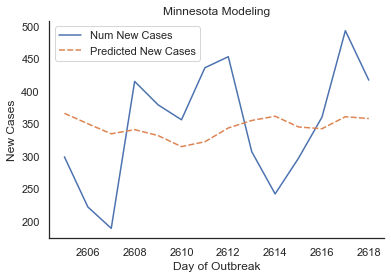

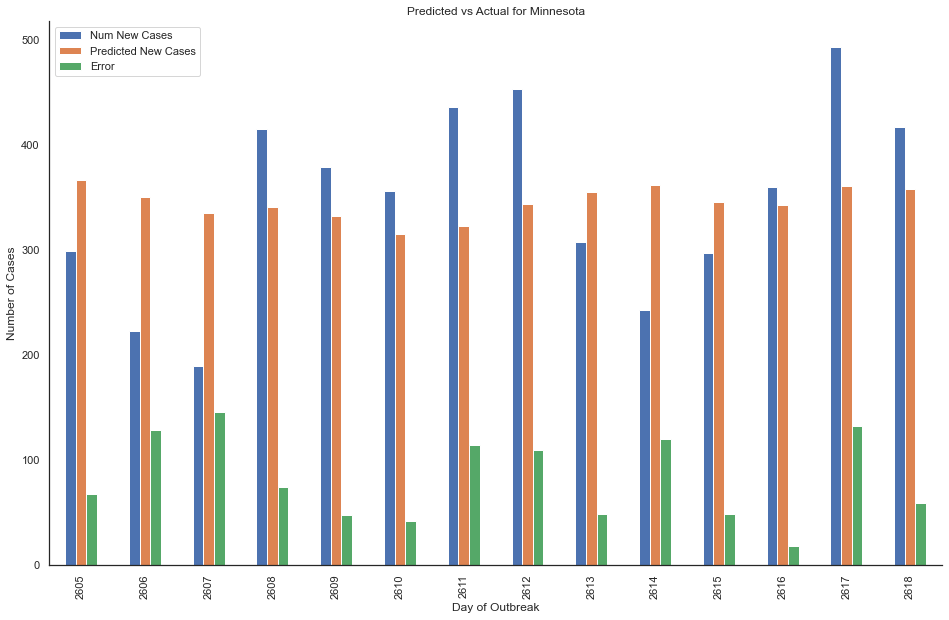

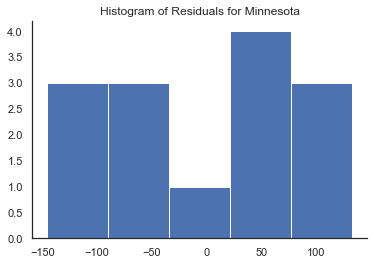

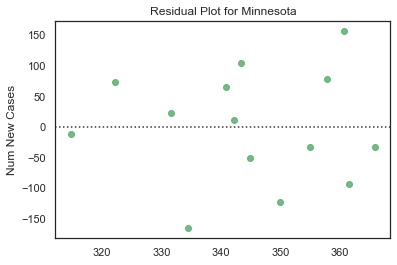

                              Coefficient
Num_New_Cases_7_avg            261.345268
Num_New_Cases_14_avg             0.000000
transit gps hits_7_avg          -0.000000
driving gps hits_7_avg          -0.000000
residential_7_avg                0.000000
workplace_7_avg                 -0.000000
transit_7_avg                    0.000000
parks_7_avg                      0.000000
grocery_and_pharmacy_7_avg       0.000000
retail_and_recreation_7_avg      0.000000
walking gps hits_7_avg          -0.000000
transit gps hits_14_avg         -0.000000
driving gps hits_14_avg         -0.000000
residential_14_avg               0.000000
transit_14_avg                  -0.000000
parks_14_avg                     0.000000
grocery_and_pharmacy_14_avg     -0.000000
retail_and_recreation_14_avg    -0.000000
workplace_14_avg                -1.181147
walking gps hits_14_avg         -8.553977


In [69]:
# Utlize model with best score from GridSearch
model= linear_model.Lasso(alpha= 10)
model.fit(x_train, y_train)
r2_train= model.score(x_train, y_train)
r2_test= model.score(x_test, y_test)
print('R2 TRAIN: {}'.format(r2_train))
print('R2 TEST: {}'.format(r2_test))


y_pred_train= model.predict(x_train)
y_pred_test= model.predict(x_test)
mae_train= mean_absolute_error(y_train, y_pred_train)
mae_test= mean_absolute_error(y_test, y_pred_test)
print('MAE TRAIN: {}'.format(mae_train))
print('MAE TEST: {}'.format(mae_test))

y_test_copy= y_test.copy()
df= y_test_copy.to_frame()
predicted= y_pred_test.tolist()
df['Predicted New Cases']= predicted

#Line plot of the predicted and actual values 
sns.lineplot(data= df)
plt.xlabel('Day of Outbreak')
plt.ylabel('New Cases')
plt.title('{} Modeling'.format(target_state))
sns.despine()
plt.savefig('Images/{} line.png'.format(target_state))
plt.show()

# Add an error colum to the df
df["Error"]= np.abs(df['Num New Cases'] - df['Predicted New Cases'])

# Bar graph of predicted vs actual 
df.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.title('Predicted vs Actual for {}'.format(target_state))
plt.xlabel('Day of Outbreak')
plt.ylabel('Number of Cases')
sns.despine()
plt.grid(b=None)
plt.savefig('Images/{} bar.png'.format(target_state))
plt.show()

# Residuals histogram
residuals= list(y_test - y_pred_test)
plt.hist(x=residuals, bins=5)
plt.title('Histogram of Residuals for {}'.format(target_state))
plt.savefig('Images/{} resid_hist.png'.format(target_state))
sns.despine()
plt.show()

# Residuals scatter plot
sns.residplot(y_pred_test, y_test, color="g")
plt.title('Residual Plot for {}'.format(target_state))
plt.show()


coeff_df = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])  
print(coeff_df.sort_values(by='Coefficient', ascending=False))

state_list.append(target_state)
r2_test_list.append(r2_test)
mae_test_list.append(mae_test)

## Texas

In [70]:
# Extract State from dataset
target_state= 'Texas'
state= full_df[full_df['state'] == target_state]

# Add lagging variables
lagged_df= state.copy()

#Add a 14 and 7 day lag for target variable
# Add a 14 day lag for num new cases
lagged_df['Num_New_Cases_14_avg']= lagged_df['Num New Cases'].rolling(14).mean()

# Add a 7 day lag for num new cases
lagged_df['Num_New_Cases_7_avg']= lagged_df['Num New Cases'].rolling(7).mean()


# Add 14 and 7 day rolling average for mobility markers
# Create a list of all the mobiity markers
mobility_markers= []
for x in lagged_df.columns[2:11]:
    mobility_markers.append(x)

# Create a 14 days running avergae for all mobility markers
for marker in mobility_markers:
    lagged_df['{}_14_avg'.format(marker)]= lagged_df[marker].rolling(14).mean()

# Create a 7 day running avergae for all mobility markers
for marker in mobility_markers:
    lagged_df['{}_7_avg'.format(marker)]= lagged_df[marker].rolling(7).mean()
    
 
lagged_df.dropna(inplace=True)
X= lagged_df.iloc[:,-20:]
y= lagged_df['Num New Cases']

# We want to split the data so that we are using the last 14 days for test
len_data= len(lagged_df)
# Make a point for which we split the data 
split_point= len_data- 14

x_train= X[:split_point]
x_test= X[split_point:]
y_train= y[:split_point]
y_test= y[split_point:]


print('Our X variables will be {}.'.format(list(x_train.columns)))
print('\n')

# scaling data
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print('\n')


# Lasso
alpha= [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid= dict(alpha= alpha)

grid= GridSearchCV(linear_model.Lasso(), param_grid, scoring='neg_mean_absolute_error', cv=5)
grid_result= grid.fit(x_train, y_train)

print('Lasso Regression')
print('Best MAE: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)
print('\n')

alpha= [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid= dict(alpha= alpha)

# Ridge
grid= GridSearchCV(linear_model.Ridge(), param_grid, scoring='neg_mean_absolute_error', cv=5)
grid_result= grid.fit(x_train, y_train)

print('Ridge Regression')
print('Best MAE: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)
print('\n')

#ElasticNet
alpha= [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid= dict(alpha= alpha)

grid= GridSearchCV(linear_model.ElasticNet(), param_grid, scoring='neg_mean_absolute_error', cv=5)
grid_result= grid.fit(x_train, y_train)

print('ElasticNet')
print('Best MAE: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

Our X variables will be ['Num_New_Cases_14_avg', 'Num_New_Cases_7_avg', 'retail_and_recreation_14_avg', 'grocery_and_pharmacy_14_avg', 'parks_14_avg', 'transit_14_avg', 'workplace_14_avg', 'residential_14_avg', 'driving gps hits_14_avg', 'transit gps hits_14_avg', 'walking gps hits_14_avg', 'retail_and_recreation_7_avg', 'grocery_and_pharmacy_7_avg', 'parks_7_avg', 'transit_7_avg', 'workplace_7_avg', 'residential_7_avg', 'driving gps hits_7_avg', 'transit gps hits_7_avg', 'walking gps hits_7_avg'].


(105, 20)
(105,)
(14, 20)
(14,)


Lasso Regression
Best MAE:  -262.2814754796291
Best Params:  {'alpha': 10}


Ridge Regression
Best MAE:  -290.9316838727374
Best Params:  {'alpha': 10}


ElasticNet
Best MAE:  -278.3252802822886
Best Params:  {'alpha': 0.1}


R2 TRAIN: 0.7661131022104738
R2 TEST: 0.508102426705844
MAE TRAIN: 182.02615284470463
MAE TEST: 853.697622493002


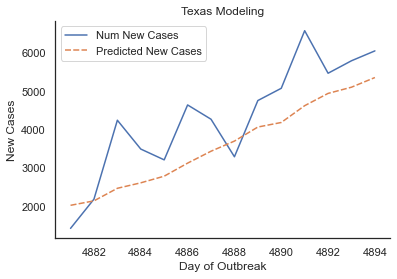

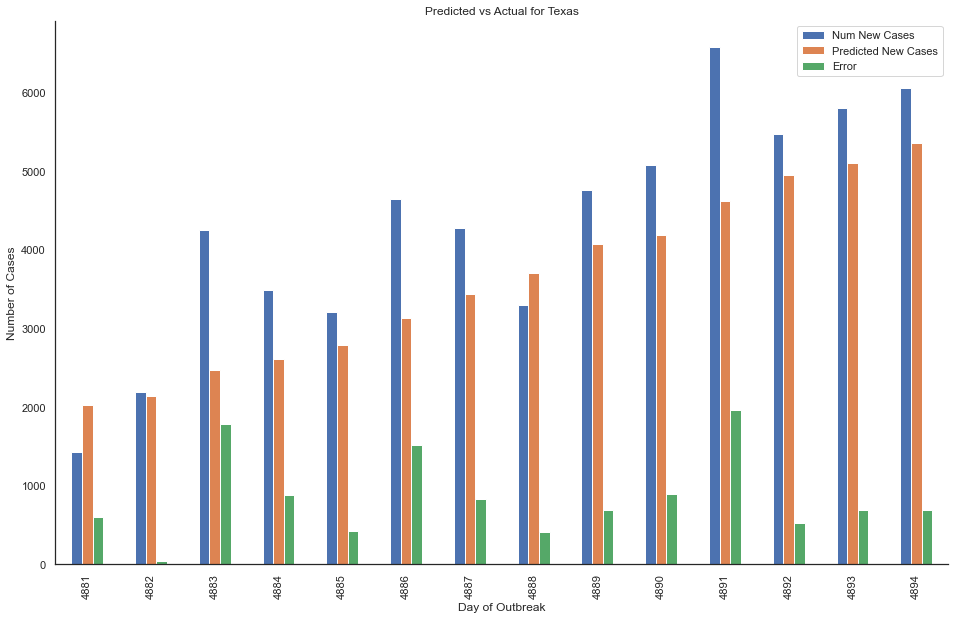

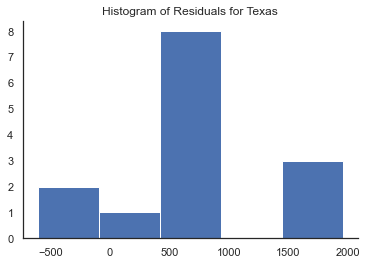

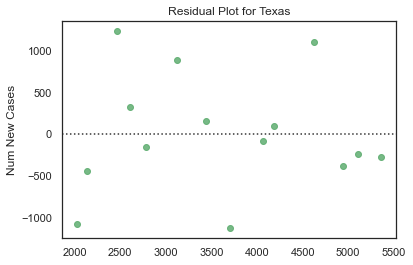

                              Coefficient
Num_New_Cases_7_avg            561.618489
parks_14_avg                    24.839734
Num_New_Cases_14_avg             0.000000
transit gps hits_7_avg          -0.000000
driving gps hits_7_avg           0.000000
residential_7_avg                0.000000
transit_7_avg                   -0.000000
parks_7_avg                      0.000000
grocery_and_pharmacy_7_avg      -0.000000
retail_and_recreation_7_avg     -0.000000
walking gps hits_14_avg          0.000000
transit gps hits_14_avg         -0.000000
driving gps hits_14_avg          0.000000
residential_14_avg               0.000000
workplace_14_avg                -0.000000
transit_14_avg                  -0.000000
grocery_and_pharmacy_14_avg      0.000000
retail_and_recreation_14_avg    -0.000000
walking gps hits_7_avg          -0.000000
workplace_7_avg                -34.424852


In [71]:
# Utlize model with best score from GridSearch
model= linear_model.Lasso(alpha= 10)
model.fit(x_train, y_train)
r2_train= model.score(x_train, y_train)
r2_test= model.score(x_test, y_test)
print('R2 TRAIN: {}'.format(r2_train))
print('R2 TEST: {}'.format(r2_test))


y_pred_train= model.predict(x_train)
y_pred_test= model.predict(x_test)
mae_train= mean_absolute_error(y_train, y_pred_train)
mae_test= mean_absolute_error(y_test, y_pred_test)
print('MAE TRAIN: {}'.format(mae_train))
print('MAE TEST: {}'.format(mae_test))

y_test_copy= y_test.copy()
df= y_test_copy.to_frame()
predicted= y_pred_test.tolist()
df['Predicted New Cases']= predicted

#Line plot of the predicted and actual values 
sns.lineplot(data= df)
plt.xlabel('Day of Outbreak')
plt.ylabel('New Cases')
plt.title('{} Modeling'.format(target_state))
sns.despine()
plt.savefig('Images/{} line.png'.format(target_state))
plt.show()

# Add an error colum to the df
df["Error"]= np.abs(df['Num New Cases'] - df['Predicted New Cases'])

# Bar graph of predicted vs actual 
df.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.title('Predicted vs Actual for {}'.format(target_state))
plt.xlabel('Day of Outbreak')
plt.ylabel('Number of Cases')
sns.despine()
plt.grid(b=None)
plt.savefig('Images/{} bar.png'.format(target_state))
plt.show()

# Residuals histogram
residuals= list(y_test - y_pred_test)
plt.hist(x=residuals, bins=5)
plt.title('Histogram of Residuals for {}'.format(target_state))
plt.savefig('Images/{} resid_hist.png'.format(target_state))
sns.despine()
plt.show()

# Residuals scatter plot
sns.residplot(y_pred_test, y_test, color="g")
plt.title('Residual Plot for {}'.format(target_state))
plt.show()


coeff_df = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])  
print(coeff_df.sort_values(by='Coefficient', ascending=False))

state_list.append(target_state)
r2_test_list.append(r2_test)
mae_test_list.append(mae_test)

## Virginia

In [72]:
# Extract State from dataset
target_state= 'Virginia'
state= full_df[full_df['state'] == target_state]

# Add lagging variables
lagged_df= state.copy()

#Add a 14 and 7 day lag for target variable
# Add a 14 day lag for num new cases
lagged_df['Num_New_Cases_14_avg']= lagged_df['Num New Cases'].rolling(14).mean()

# Add a 7 day lag for num new cases
lagged_df['Num_New_Cases_7_avg']= lagged_df['Num New Cases'].rolling(7).mean()


# Add 14 and 7 day rolling average for mobility markers
# Create a list of all the mobiity markers
mobility_markers= []
for x in lagged_df.columns[2:11]:
    mobility_markers.append(x)

# Create a 14 days running avergae for all mobility markers
for marker in mobility_markers:
    lagged_df['{}_14_avg'.format(marker)]= lagged_df[marker].rolling(14).mean()

# Create a 7 day running avergae for all mobility markers
for marker in mobility_markers:
    lagged_df['{}_7_avg'.format(marker)]= lagged_df[marker].rolling(7).mean()
    
 
lagged_df.dropna(inplace=True)
X= lagged_df.iloc[:,-20:]
y= lagged_df['Num New Cases']

# We want to split the data so that we are using the last 14 days for test
len_data= len(lagged_df)
# Make a point for which we split the data 
split_point= len_data- 14

x_train= X[:split_point]
x_test= X[split_point:]
y_train= y[:split_point]
y_test= y[split_point:]


print('Our X variables will be {}.'.format(list(x_train.columns)))
print('\n')

# scaling data
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print('\n')


# Lasso
alpha= [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid= dict(alpha= alpha)

grid= GridSearchCV(linear_model.Lasso(), param_grid, scoring='neg_mean_absolute_error', cv=5)
grid_result= grid.fit(x_train, y_train)

print('Lasso Regression')
print('Best MAE: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)
print('\n')

alpha= [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid= dict(alpha= alpha)

# Ridge
grid= GridSearchCV(linear_model.Ridge(), param_grid, scoring='neg_mean_absolute_error', cv=5)
grid_result= grid.fit(x_train, y_train)

print('Ridge Regression')
print('Best MAE: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)
print('\n')

#ElasticNet
alpha= [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid= dict(alpha= alpha)

grid= GridSearchCV(linear_model.ElasticNet(), param_grid, scoring='neg_mean_absolute_error', cv=5)
grid_result= grid.fit(x_train, y_train)

print('ElasticNet')
print('Best MAE: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

Our X variables will be ['Num_New_Cases_14_avg', 'Num_New_Cases_7_avg', 'retail_and_recreation_14_avg', 'grocery_and_pharmacy_14_avg', 'parks_14_avg', 'transit_14_avg', 'workplace_14_avg', 'residential_14_avg', 'driving gps hits_14_avg', 'transit gps hits_14_avg', 'walking gps hits_14_avg', 'retail_and_recreation_7_avg', 'grocery_and_pharmacy_7_avg', 'parks_7_avg', 'transit_7_avg', 'workplace_7_avg', 'residential_7_avg', 'driving gps hits_7_avg', 'transit gps hits_7_avg', 'walking gps hits_7_avg'].


(84, 20)
(84,)
(14, 20)
(14,)


Lasso Regression
Best MAE:  -198.34529859057812
Best Params:  {'alpha': 10}


Ridge Regression
Best MAE:  -173.3344454794651
Best Params:  {'alpha': 10}


ElasticNet
Best MAE:  -195.8913885577179
Best Params:  {'alpha': 0.1}


R2 TRAIN: 0.6516173951158242
R2 TEST: -0.318555007075199
MAE TRAIN: 141.22668562082396
MAE TEST: 81.98619810907623


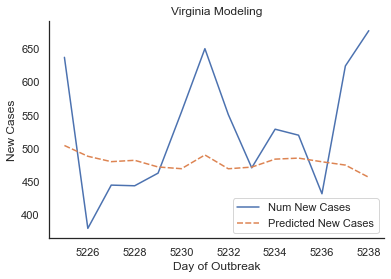

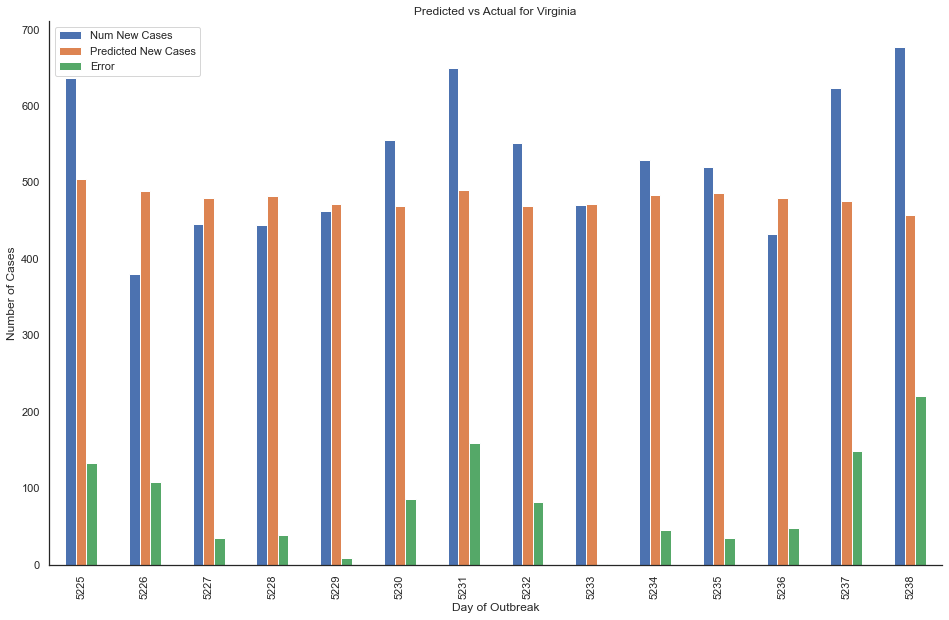

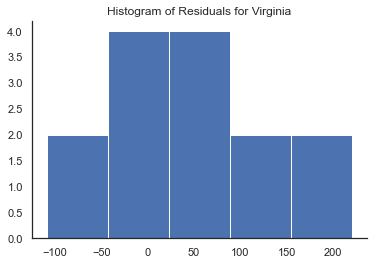

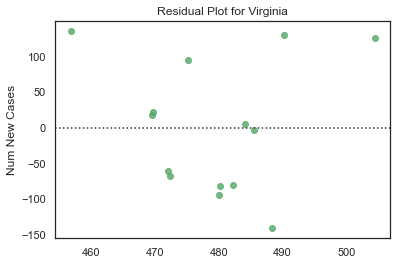

                              Coefficient
Num_New_Cases_7_avg            143.589099
Num_New_Cases_14_avg           140.927952
grocery_and_pharmacy_7_avg      85.449377
retail_and_recreation_7_avg     40.534604
residential_7_avg               36.534890
retail_and_recreation_14_avg    19.814721
residential_14_avg              17.337493
transit gps hits_7_avg          16.522101
transit_7_avg                   16.264402
driving gps hits_14_avg         15.474943
grocery_and_pharmacy_14_avg     13.526093
driving gps hits_7_avg          13.232579
transit gps hits_14_avg         11.728617
transit_14_avg                   9.249138
parks_14_avg                    -9.383567
walking gps hits_14_avg        -22.370917
parks_7_avg                    -28.431809
walking gps hits_7_avg         -33.662876
workplace_14_avg               -61.257670
workplace_7_avg               -107.486126


In [73]:
# Utlize model with best score from GridSearch
model= linear_model.Ridge(alpha= 10)
model.fit(x_train, y_train)
r2_train= model.score(x_train, y_train)
r2_test= model.score(x_test, y_test)
print('R2 TRAIN: {}'.format(r2_train))
print('R2 TEST: {}'.format(r2_test))


y_pred_train= model.predict(x_train)
y_pred_test= model.predict(x_test)
mae_train= mean_absolute_error(y_train, y_pred_train)
mae_test= mean_absolute_error(y_test, y_pred_test)
print('MAE TRAIN: {}'.format(mae_train))
print('MAE TEST: {}'.format(mae_test))

y_test_copy= y_test.copy()
df= y_test_copy.to_frame()
predicted= y_pred_test.tolist()
df['Predicted New Cases']= predicted

#Line plot of the predicted and actual values 
sns.lineplot(data= df)
plt.xlabel('Day of Outbreak')
plt.ylabel('New Cases')
plt.title('{} Modeling'.format(target_state))
sns.despine()
plt.savefig('Images/{} line.png'.format(target_state))
plt.show()

# Add an error colum to the df
df["Error"]= np.abs(df['Num New Cases'] - df['Predicted New Cases'])

# Bar graph of predicted vs actual 
df.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.title('Predicted vs Actual for {}'.format(target_state))
plt.xlabel('Day of Outbreak')
plt.ylabel('Number of Cases')
sns.despine()
plt.grid(b=None)
plt.savefig('Images/{} bar.png'.format(target_state))
plt.show()

# Residuals histogram
residuals= list(y_test - y_pred_test)
plt.hist(x=residuals, bins=5)
plt.title('Histogram of Residuals for {}'.format(target_state))
plt.savefig('Images/{} resid_hist.png'.format(target_state))
sns.despine()
plt.show()

# Residuals scatter plot
sns.residplot(y_pred_test, y_test, color="g")
plt.title('Residual Plot for {}'.format(target_state))
plt.show()


coeff_df = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])  
print(coeff_df.sort_values(by='Coefficient', ascending=False))

state_list.append(target_state)
r2_test_list.append(r2_test)
mae_test_list.append(mae_test)

## New York

In [74]:
# Extract State from dataset
target_state= 'New York'
state= full_df[full_df['state'] == target_state]

# Add lagging variables
lagged_df= state.copy()

#Add a 14 and 7 day lag for target variable
# Add a 14 day lag for num new cases
lagged_df['Num_New_Cases_14_avg']= lagged_df['Num New Cases'].rolling(14).mean()

# Add a 7 day lag for num new cases
lagged_df['Num_New_Cases_7_avg']= lagged_df['Num New Cases'].rolling(7).mean()


# Add 14 and 7 day rolling average for mobility markers
# Create a list of all the mobiity markers
mobility_markers= []
for x in lagged_df.columns[2:11]:
    mobility_markers.append(x)

# Create a 14 days running avergae for all mobility markers
for marker in mobility_markers:
    lagged_df['{}_14_avg'.format(marker)]= lagged_df[marker].rolling(14).mean()

# Create a 7 day running avergae for all mobility markers
for marker in mobility_markers:
    lagged_df['{}_7_avg'.format(marker)]= lagged_df[marker].rolling(7).mean()
    
 
lagged_df.dropna(inplace=True)
X= lagged_df.iloc[:,-20:]
y= lagged_df['Num New Cases']

# We want to split the data so that we are using the last 14 days for test
len_data= len(lagged_df)
# Make a point for which we split the data 
split_point= len_data- 14

x_train= X[:split_point]
x_test= X[split_point:]
y_train= y[:split_point]
y_test= y[split_point:]


print('Our X variables will be {}.'.format(list(x_train.columns)))
print('\n')

# scaling data
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print('\n')


# Lasso
alpha= [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid= dict(alpha= alpha)

grid= GridSearchCV(linear_model.Lasso(), param_grid, scoring='neg_mean_absolute_error', cv=5)
grid_result= grid.fit(x_train, y_train)

print('Lasso Regression')
print('Best MAE: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)
print('\n')

alpha= [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid= dict(alpha= alpha)

# Ridge
grid= GridSearchCV(linear_model.Ridge(), param_grid, scoring='neg_mean_absolute_error', cv=5)
grid_result= grid.fit(x_train, y_train)

print('Ridge Regression')
print('Best MAE: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)
print('\n')

#ElasticNet
alpha= [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid= dict(alpha= alpha)

grid= GridSearchCV(linear_model.ElasticNet(), param_grid, scoring='neg_mean_absolute_error', cv=5)
grid_result= grid.fit(x_train, y_train)

print('ElasticNet')
print('Best MAE: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

Our X variables will be ['Num_New_Cases_14_avg', 'Num_New_Cases_7_avg', 'retail_and_recreation_14_avg', 'grocery_and_pharmacy_14_avg', 'parks_14_avg', 'transit_14_avg', 'workplace_14_avg', 'residential_14_avg', 'driving gps hits_14_avg', 'transit gps hits_14_avg', 'walking gps hits_14_avg', 'retail_and_recreation_7_avg', 'grocery_and_pharmacy_7_avg', 'parks_7_avg', 'transit_7_avg', 'workplace_7_avg', 'residential_7_avg', 'driving gps hits_7_avg', 'transit gps hits_7_avg', 'walking gps hits_7_avg'].


(90, 20)
(90,)
(14, 20)
(14,)


Lasso Regression
Best MAE:  -1216.363018336425
Best Params:  {'alpha': 10}


Ridge Regression
Best MAE:  -1658.0838163883939
Best Params:  {'alpha': 10}


ElasticNet
Best MAE:  -1635.7769300647692
Best Params:  {'alpha': 0.01}


R2 TRAIN: 0.8930524833047477
R2 TEST: -49.194226169858126
MAE TRAIN: 726.6255447601329
MAE TEST: 536.9497833976005


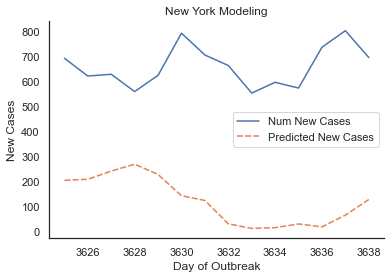

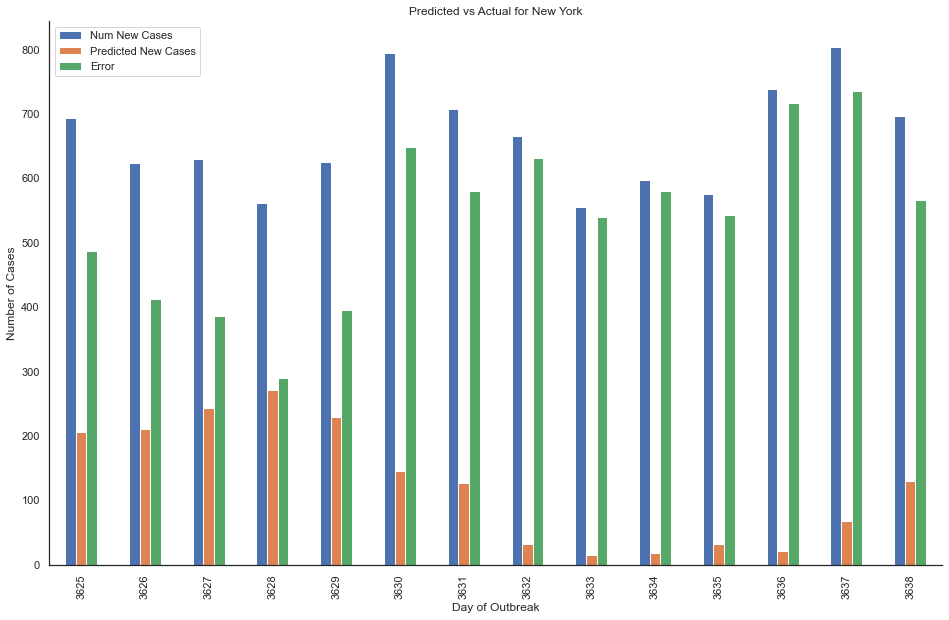

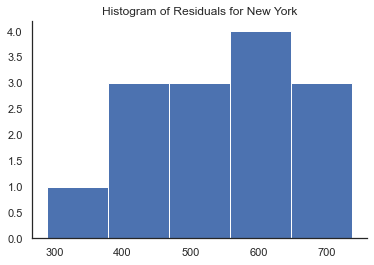

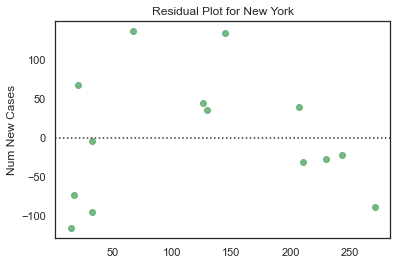

                              Coefficient
Num_New_Cases_7_avg           2910.473669
residential_7_avg             1928.546005
retail_and_recreation_14_avg  1694.896497
retail_and_recreation_7_avg    211.073988
workplace_14_avg               160.034666
parks_14_avg                    12.862181
walking gps hits_14_avg          0.000000
grocery_and_pharmacy_7_avg       0.000000
transit gps hits_7_avg          -0.000000
driving gps hits_7_avg           0.000000
workplace_7_avg                 -0.000000
parks_7_avg                      0.000000
walking gps hits_7_avg           0.000000
transit gps hits_14_avg         -0.000000
driving gps hits_14_avg          0.000000
residential_14_avg              -0.000000
transit_14_avg                   0.000000
transit_7_avg                  -88.563020
grocery_and_pharmacy_14_avg   -302.910820
Num_New_Cases_14_avg          -445.090458


In [75]:
# Utlize model with best score from GridSearch
model= linear_model.Lasso(alpha= 10)
model.fit(x_train, y_train)
r2_train= model.score(x_train, y_train)
r2_test= model.score(x_test, y_test)
print('R2 TRAIN: {}'.format(r2_train))
print('R2 TEST: {}'.format(r2_test))


y_pred_train= model.predict(x_train)
y_pred_test= model.predict(x_test)
mae_train= mean_absolute_error(y_train, y_pred_train)
mae_test= mean_absolute_error(y_test, y_pred_test)
print('MAE TRAIN: {}'.format(mae_train))
print('MAE TEST: {}'.format(mae_test))

y_test_copy= y_test.copy()
df= y_test_copy.to_frame()
predicted= y_pred_test.tolist()
df['Predicted New Cases']= predicted

#Line plot of the predicted and actual values 
sns.lineplot(data= df)
plt.xlabel('Day of Outbreak')
plt.ylabel('New Cases')
plt.title('{} Modeling'.format(target_state))
sns.despine()
plt.savefig('Images/{} line.png'.format(target_state))
plt.show()

# Add an error colum to the df
df["Error"]= np.abs(df['Num New Cases'] - df['Predicted New Cases'])

# Bar graph of predicted vs actual 
df.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.title('Predicted vs Actual for {}'.format(target_state))
plt.xlabel('Day of Outbreak')
plt.ylabel('Number of Cases')
sns.despine()
plt.grid(b=None)
plt.savefig('Images/{} bar.png'.format(target_state))
plt.show()

# Residuals histogram
residuals= list(y_test - y_pred_test)
plt.hist(x=residuals, bins=5)
plt.title('Histogram of Residuals for {}'.format(target_state))
plt.savefig('Images/{} resid_hist.png'.format(target_state))
sns.despine()
plt.show()

# Residuals scatter plot
sns.residplot(y_pred_test, y_test, color="g")
plt.title('Residual Plot for {}'.format(target_state))
plt.show()


coeff_df = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])  
print(coeff_df.sort_values(by='Coefficient', ascending=False))

state_list.append(target_state)
r2_test_list.append(r2_test)
mae_test_list.append(mae_test)

### Summary Table

In [76]:
summary= pd.DataFrame()
summary['State']= state_list
summary['R2_Test']= r2_test_list
summary['MAE_Test']= mae_test_list
summary

,State,R2_Test,MAE_Test
0,Alabama,0.070175,186.975599
1,Washington,0.177980,86.895380
2,Oregon,0.138774,57.128520
3,Ohio,-0.533123,197.980633
4,Florida,0.741066,771.028057
5,Colorado,0.181774,44.681297
6,Minnesota,-0.066840,82.210855
7,Texas,0.508102,853.697622
8,Virginia,-0.318555,81.986198
9,New York,-49.194226,536.949783
